In [1]:
from IPython.display import display, HTML
display(HTML("<style>div.container { width:100% !important; }</style>"))

# 객체 탐지 원리

## 라벨링

In [2]:
import cv2

### labelset

In [3]:
def labelset(img, xs, ys, label):
    height, width = img.shape
    img[ys, xs] = label
    while True:
        cnt = 0
        for y in range(1, height-1):
            for x in range(1, width-1):
                if img[y,x] == label :
                    if  img[y  , x+1] == 255 :
                        img[y  , x+1] = label; cnt = cnt+1
                    if  img[y-1, x+1] == 255 :
                        img[y-1, x+1] = label; cnt = cnt+1
                    if  img[y-1, x  ] == 255 :
                        img[y-1, x  ] = label; cnt = cnt+1
                    if  img[y-1, x-1] == 255 :
                        img[y-1, x-1] = label; cnt = cnt+1
                    if  img[y  , x-1] == 255 :
                        img[y  , x-1] = label; cnt = cnt+1
                    if  img[y+1, x-1] == 255 :
                        img[y+1, x-1] = label; cnt = cnt+1
                    if  img[y+1, x  ] == 255 :
                        img[y+1, x  ] = label; cnt = cnt+1
                    if  img[y+1, x+1] == 255 :
                        img[y+1, x+1] = label; cnt = cnt+1
        if cnt==0:
            return (0, img)
    return (1, img)

### labeling

In [4]:
def labeling(img_in, base=100):
    height, width = img_in.shape
    img_label = img_in.copy()
            
    label = base # 베이스 값부터 라벨링 함
    
    for y in range(1, height-1):
        for x in range(1, width-1):
            if img_label[y,x] == 255 :
                if label >= 255:
                    print("Error! too many labels")
                    return -1
                
                _, img_label = labelset(img_label, x, y, label)
                label = label + 1
    cnt = label - base
    
    return img_label, cnt

In [5]:
img = cv2.imread('images/shape.png', 0)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img)
print("객체 수", cnt)

객체 수 4


In [7]:
# 원, A, 세모, 네모 안의 임의 좌표
labeled_img[80, 80],labeled_img[69,173], labeled_img[160,190], labeled_img[160,60] 

(100, 101, 102, 103)

In [8]:
# labeled_img.shape
cv2.imshow('Labeling', labeled_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
cv2.imwrite('shape_labeled.png',labeled_img)

True

## 경계 찾기와 주위 길이 계산

### trace() 함수

In [10]:
def trace(image_label, xs, ys):
    length = 0
    x, y = xs, ys
    no = image_label[y,x+1]
    vec = 5
    
    while True:
        if (x==xs) & (y==ys) & (length!=0):
            return (length, image_label)
        image_label[y,x] = 255
#         if no==101:
#             print(x,y)

        if vec==3:
            if (image_label[y  ,x+1]!=no) & (image_label[y-1,x+1]==no):
                x=x+1; y=y  ; length=length+1;          vec=0; continue
            else:
                vec=4
        if vec==4:
            if (image_label[y-1,x+1]!=no) & (image_label[y-1,x  ]==no):
                x=x+1; y=y-1; length=length+np.sqrt(2); vec=1; continue
            else:
                vec=5
        if vec==5:
            if (image_label[y-1,x  ]!=no) & (image_label[y-1,x-1]==no):
                x=x  ; y=y-1; length=length+1;          vec=2; continue
            else:
                vec=6
        if vec==6:
            if (image_label[y-1,x-1]!=no) & (image_label[y  ,x-1]==no):
                x=x-1; y=y-1; length=length+np.sqrt(2); vec=3; continue
            else:
                vec=7
        if vec==7:
            if (image_label[y  ,x-1]!=no) & (image_label[y+1,x-1]==no):
                x=x-1; y=y  ; length=length+1;          vec=4; continue
            else:
                vec=0
        if vec==0:
            if (image_label[y+1,x-1]!=no) & (image_label[y+1,x  ]==no):
                x=x-1; y=y+1; length=length+np.sqrt(2); vec=5; continue
            else:
                vec=1
        if vec==1:
            if (image_label[y+1,x  ]!=no) & (image_label[y+1,x+1]==no):
                x=x  ; y=y+1; length=length+1;          vec=6; continue
            else:
                vec=2
        if vec==2:
            if (image_label[y+1,x+1]!=no) & (image_label[y  ,x+1]==no):
                x=x+1; y=y+1; length=length+np.sqrt(2); vec=7; continue
            else:
                vec=3
    

### contour_length

In [11]:
def contour_length(image_label, label):
    height, width = image_label.shape
    for y in range(height):
        for x in range(width):
            if image_label[y,x] == label:
                length, image_label = trace(image_label, x-1, y)
                return length, image_label

In [12]:
import numpy as np
img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img, 100)
length, contour_image = contour_length(labeled_img, 100)
print(length)
cv2.imshow('Contour', contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

263.7645019878176


## 특징 파라미터

### 면적과 중심위치

In [13]:
def contour_area(image_label, label):
    tx, ty = 0, 0
    cx, cy = 0, 0 # 반환할 중심점
    total = 0
    height, width = image_label.shape
    for y in range(height):
        for x in range(width):
            if image_label[y,x]==label:
                tx = tx + x
                ty = ty + y
                total = total + 1
    if total==0:
        return 0
    cx = int(tx/total)
    cy = int(ty/total)
    return (cx, cy, total)

In [14]:
import cv2

img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img, base=100)
for i in range(cnt):
    cx, cy, area = contour_area(labeled_img, i+100)
    print(cx, cy, area)

76 79 4880
172 87 1797
192 168 1108
81 163 2759


### 원형도

In [15]:
import cv2

img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img, base=100)
for i in range(cnt):
    cx, cy, area = contour_area(labeled_img, i+100)
    length, featured_img = contour_length(labeled_img, i+100)
    ratio = 4*np.pi*area / (length*length)
    print(ratio)

0.8814486001080429
0.4382536609116099
0.49200158512447256
0.5936949146124189


### features

In [16]:
import numpy as np
def features(image_label, cnt):
    areas = []; centers = []; lengths = []; ratios = []
    featured_img = np.zeros(image_label.shape, dtype=np.uint8)
    for i in range(cnt):
        cx, cy, area = contour_area(image_label, i+100)
        centers.append((cx, cy)); areas.append(area)
#         print(i+100, cx, cy, area, end=" ")
        
        length, featured_img = contour_length(image_label, i+100)
        lengths.append(length)
        ratio = 4*np.pi*area / (length*length)
        ratios.append(ratio)
#         print(length, ratio)
    
    return ((areas, centers, lengths, ratios), featured_img)

### 실행

In [17]:
img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img, 100)
feat, featured_img = features(labeled_img, cnt)
areas, centers, lengths, ratios = feat
print(areas)
print(centers)
print(lengths)
print(ratios)

[4880, 1797, 1108, 2759]
[(76, 79), (172, 87), (192, 168), (81, 163)]
[263.7645019878176, 226.99494936611694, 168.2253967444163, 241.6568542494924]
[0.8814486001080429, 0.4382536609116099, 0.49200158512447256, 0.5936949146124189]


In [18]:
cv2.imshow('Featured', featured_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
cv2.imwrite('shape_featured.png',featured_img)

True

# OpenCV를 이용한 객체 탐지

## 라벨링과 경계 찾기

### cv2.connectedComponents()

In [20]:
import cv2

img = cv2.imread('images/shape.png', 0)
ret, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
cnt, labeled_img = cv2.connectedComponents(bin_img)

In [21]:
print("객체 수", cnt)

print(labeled_img[80,80], labeled_img[69,173], end=" ")
print(labeled_img[160,190], labeled_img[160,60])

객체 수 5
1 2 3 4


In [22]:
labeled_img.dtype

dtype('int32')

In [23]:
labeled_img = labeled_img*50
import numpy as np

cv2.imshow('Labeling', labeled_img.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

### cv2.findContours()

### cv2.drawContours()

In [24]:
import cv2
import numpy as np

img = cv2.imread('images/shape.png')
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, bin_img  = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, 
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)

image = cv2.drawContours(img, contours, -1, (0,255,0), 3)

cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
import cv2
import numpy as np

img = cv2.imread('images/lena.jpg')
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, bin_img  = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, 
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)

image = cv2.drawContours(img, contours, -1, (0,255,0), 3)

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 객체 정보

### 모멘트

In [26]:
import numpy as np

def get_moments(img):
    M = {}
    x, y = np.mgrid[:img.shape[0],:img.shape[1]]
    img = img.astype(float)
    # 공간 모멘트 
    M['m00'] = np.sum(img)
    M['m01'] = np.sum(y*img)
    M['m10'] = np.sum(x*img)
    M['m11'] = np.sum(x*y*img)
    M['m02'] = np.sum(y**2*img)
    M['m20'] = np.sum(x**2*img)
    M['m12'] = np.sum(x**2*y*img)
    M['m21'] = np.sum(x*y**2*img)
    M['m22'] = np.sum(x**2*y**2*img)
    M['m03'] = np.sum(x**3*img)
    M['m30'] = np.sum(y**3*img)
 
    # 이미지 중심 
    cX = M['m10'] / M['m00']
    cY = M['m01'] / M['m00']
 
    # 중심 모멘트 
    M['mu00'] = M['m00']
    M['mu01'] = 0 
    M['mu10'] = 0 
    M['mu11'] = np.sum((x-cX)*(y-cY)*img)
    M['mu02'] = np.sum((x-cX)**2*img)
    M['mu20'] = np.sum((y-cY)**2*img)
    M['mu12'] = np.sum((x-cX)**2*(y-cY)*img)
    M['mu21'] = np.sum((x-cX)*(y-cY)**2*img)
    M['mu03'] = np.sum((x-cX)**3*img)
    M['mu30'] = np.sum((y-cY)**3*img)

    # 정규화된 중심 모멘트 
    M['nu00'] = 1 
    M['nu01'] = 0 
    M['nu10'] = 0 
    M['nu11'] = M['mu11'] / M['mu00']**(2/2+1)
    M['nu02'] = M['mu02'] / M['mu00']**(2/2+1)
    M['nu20'] = M['mu20'] / M['mu00']**(2/2+1)
    M['nu12'] = M['mu12'] / M['mu00']**(3/2+1)
    M['nu21'] = M['mu21'] / M['mu00']**(3/2+1)
    M['nu03'] = M['mu03'] / M['mu00']**(3/2+1)
    M['nu30'] = M['mu30'] / M['mu00']**(3/2+1)
 
    return M

In [27]:
import cv2
import numpy as np

img_gray = cv2.imread('images/shape.png', cv2.IMREAD_GRAYSCALE)
M = get_moments(img_gray)
print(M.items())

dict_items([('m00', 2688720.0), ('m01', 284959695.0), ('m10', 300861495.0), ('m11', 32849201745.0), ('m02', 36926195805.0), ('m20', 38710487925.0), ('m12', 4322818373835.0), ('m21', 4398836072445.0), ('m22', 593249327976495.0), ('m03', 5514704232795.0), ('m30', 5552696245215.0), ('mu00', 2688720.0), ('mu01', 0), ('mu10', 0), ('mu11', 962876708.386286), ('mu02', 5044788568.564587), ('mu20', 6725197644.353661), ('mu12', 4661821876.916954), ('mu21', 62783013426.67582), ('mu03', 54090806819.27515), ('mu30', 213613695450.5935), ('nu00', 1), ('nu01', 0), ('nu10', 0), ('nu11', 0.0001331924249912628), ('nu02', 0.000697833499515657), ('nu20', 0.0009302804554263222), ('nu12', 3.9327082693258106e-07), ('nu21', 5.296368728690485e-06), ('nu03', 4.563095049297564e-06), ('nu30', 1.8020429967508165e-05)])


### cv2.moments()

In [28]:
import cv2
import numpy as np

img_gray = cv2.imread('images/shape.png', cv2.IMREAD_GRAYSCALE)
M = cv2.moments(img_gray)
print(M.items())

dict_items([('m00', 2688720.0), ('m10', 284959695.0), ('m01', 300861495.0), ('m20', 36926195805.0), ('m11', 32849201745.0), ('m02', 38710487925.0), ('m30', 5552696245215.0), ('m21', 4398836072445.0), ('m12', 4322818373835.0), ('m03', 5514704232795.0), ('mu20', 6725197644.353661), ('mu11', 962876708.3862839), ('mu02', 5044788568.564587), ('mu30', 213613695450.59375), ('mu21', 62783013426.6763), ('mu12', 4661821876.91745), ('mu03', 54090806819.27539), ('nu20', 0.0009302804554263222), ('nu11', 0.0001331924249912625), ('nu02', 0.000697833499515657), ('nu30', 1.802042996750819e-05), ('nu21', 5.2963687286905265e-06), ('nu12', 3.9327082693262293e-07), ('nu03', 4.563095049297585e-06)])


### cv2.contourArea()

### cv2.arcLength()

In [29]:
import cv2
import numpy as np

img = cv2.imread('images/shape.png')
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, bin_img  = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, 
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)

for cont in contours:
    M = cv2.moments(cont)
    print(M.items())
    center_x = int(M['m10'] / M['m00'])
    center_y = int(M['m01'] / M['m00'])
    
    cv2.circle(img, (center_x, center_y), 3, (255, 0, 0), -1)
    cv2.drawContours(img, [cont], 0, (0, 0, 255), 2)
    print(cv2.contourArea(cont))
    print(cv2.arcLength(cont, True))
    
cv2.imshow('Moments', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

dict_items([('m00', 2640.0), ('m10', 213840.0), ('m01', 430320.0), ('m20', 19024720.0), ('m11', 34855920.0), ('m02', 70340160.0), ('m30', 1816998480.0), ('m21', 3101029360.0), ('m12', 5697552960.0), ('m03', 11529994080.0), ('mu20', 1703680.0), ('mu11', 0.0), ('mu02', 198000.0), ('mu30', 0.0), ('mu21', 0.0), ('mu12', 0.0), ('mu03', 0.0), ('nu20', 0.24444444444444446), ('nu11', 0.0), ('nu02', 0.02840909090909091), ('nu30', 0.0), ('nu21', 0.0), ('nu12', 0.0), ('nu03', 0.0)])
2640.0
236.0
dict_items([('m00', 1034.0), ('m10', 198528.0), ('m01', 174221.3333333333), ('m20', 38184238.0), ('m11', 33450496.0), ('m02', 29513652.333333332), ('m30', 7357048704.0), ('m21', 6434229694.833333), ('m12', 5666621248.0), ('m03', 5025178420.0), ('mu20', 66862.0), ('mu11', 3.725290298461914e-09), ('mu02', 158649.44315495715), ('mu30', 0.0), ('mu21', 468711.58639460243), ('mu12', -1.1920928955078125e-06), ('mu03', -1115676.79678154), ('nu20', 0.0625371788588382), ('nu11', 3.4843281040951126e-15), ('nu02', 0.

In [30]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np

img = cv2.imread('images/shape.png')
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, bin_img = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, 
                                      cv2.RETR_TREE, 
                                      cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0] # 첫번째 contours의 특징추출
M = cv2.moments(cnt, binaryImage=False)

print(M.items())

dict_items([('m00', 2640.0), ('m10', 213840.0), ('m01', 430320.0), ('m20', 19024720.0), ('m11', 34855920.0), ('m02', 70340160.0), ('m30', 1816998480.0), ('m21', 3101029360.0), ('m12', 5697552960.0), ('m03', 11529994080.0), ('mu20', 1703680.0), ('mu11', 0.0), ('mu02', 198000.0), ('mu30', 0.0), ('mu21', 0.0), ('mu12', 0.0), ('mu03', 0.0), ('nu20', 0.24444444444444446), ('nu11', 0.0), ('nu02', 0.02840909090909091), ('nu30', 0.0), ('nu21', 0.0), ('nu12', 0.0), ('nu03', 0.0)])


In [31]:
cv2.contourArea(cnt) # 면적, m00과 같음

2640.0

In [32]:
cv2.arcLength(cnt, True) # 폐곡선 도형을 만들어 둘레 길이 구함

236.0

In [33]:
cv2.arcLength(cnt, False) # 시작점과 끝점을 연결하지 않고 둘레 길이 구함

148.0

# 경계 근사와 경계상자 찾기

## 경계 근사

### cv2.approxPolyDP()

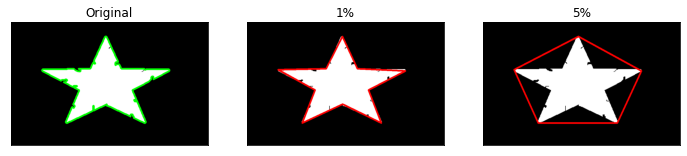

In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/star.png')
img1 = img.copy()
img2 = img.copy()

imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, bin_img  = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont = contours[0]

epsilon1 = 0.01*cv2.arcLength(cont, True)
epsilon2 = 0.05*cv2.arcLength(cont, True)

approx1 = cv2.approxPolyDP(cont, epsilon1, True)
approx2 = cv2.approxPolyDP(cont, epsilon2, True)

cv2.drawContours(img, [cont], 0, (0,255,0), 5)
cv2.drawContours(img1, [approx1], 0,(255,0,0), 5)
cv2.drawContours(img2, [approx2], 0,(255,0,0), 5)

titles = ['Original', '1%', '5%']
images = [img, img1, img2]
 
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### cv2.convexHull()

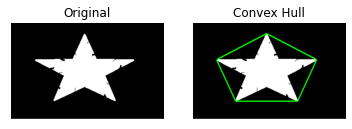

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/star.png')
img1 = img.copy()

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bin_img  = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

contours, hierachy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour = contours[1]    # 1이 별 모양 주변의 contour 
hull = cv2.convexHull(contour)

cv2.drawContours(img1, [hull], 0, (0,255,0), 5)

titles = ['Original','Convex Hull']
images = [img, img1]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

## 경계상자 찾기

### cv2.boundignRect()

### cv2.minAreaRect()

### v2.minEnclosingCircle()

### cv2.fitEllipse()

사각형 회전각도: 49.02826690673828
타원형 회전각도: 135.7649688720703


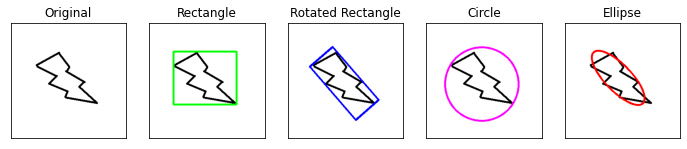

In [36]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/lightning.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bin_img = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)

contours, hierachy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont = contours[1] # 이 도형의 0번째 컨투어는 이미지 전체 
 
x, y, w, h = cv2.boundingRect(cont)
img_rect = cv2.rectangle(img.copy(), (x,y), (x+w,y+h), (0,255,0), 3)

rect = cv2.minAreaRect(cont) # 직사각형의 왼쪽상단좌표와 너비,높이, 회전각도
print("사각형 회전각도:", rect[-1])
box = np.int_(cv2.boxPoints(rect))
img_rotated_rect = cv2.drawContours(img.copy(), [box], 0, (0,0,255), 3)
(x,y), radius = cv2.minEnclosingCircle(cont)
center = (int(x), int(y))
radius = int(radius)
img_circle = cv2.circle(img.copy(), center, radius, (255,0,255), 3)

ellipse = cv2.fitEllipse(cont)
print("타원형 회전각도:", ellipse[-1])
img_ellipse = cv2.ellipse(img.copy(), ellipse, (255,0,0), 3)

titles = ['Original', 'Rectangle', 'Rotated Rectangle','Circle','Ellipse']
images = [img, img_rect, img_rotated_rect, img_circle, img_ellipse]
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1, 5, i+1), plt.imshow(images[i]), 
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])
plt.show()

In [37]:
cv2.isContourConvex(contours[0]) # 외곽선 contour line

True

# OpenCV와 딥러닝을 이용한 객체 탐지

## 필기체 숫자 데이터 불러오기

In [38]:
import cv2
import numpy as np

img = cv2.imread('images/digits.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)

(1000, 2000)


In [39]:
cv2.imshow("number", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]
x = np.array(cells)

In [41]:
x.shape

(50, 100, 20, 20)

In [42]:
# x[0,0] # 숫자 0

In [43]:
X = x[:,:].reshape(-1,400).astype(np.float32)
y = np.repeat(np.arange(10),500)

In [44]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [45]:
test_y[:100]

array([8, 1, 5, 9, 8, 4, 1, 7, 8, 6, 4, 1, 9, 0, 5, 5, 5, 8, 7, 2, 7, 5,
       8, 6, 3, 1, 7, 7, 0, 0, 5, 1, 3, 0, 6, 4, 1, 5, 5, 1, 1, 9, 1, 7,
       5, 5, 7, 1, 1, 3, 9, 9, 7, 4, 2, 5, 1, 0, 0, 4, 2, 6, 7, 8, 0, 9,
       2, 1, 9, 6, 5, 4, 6, 0, 5, 2, 4, 0, 5, 3, 1, 1, 2, 0, 9, 3, 9, 0,
       8, 6, 9, 8, 9, 2, 7, 0, 5, 1, 0, 8])

## 머신러닝 분류 모형 만들기

In [46]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [47]:
model.fit(train_X, train_y)

RandomForestClassifier()

In [48]:
model.score(test_X, test_y)

0.944

## 머신러닝 모델 저장하기

In [49]:
import pickle
with open("number.model", "wb") as f:
    pickle.dump(model, f)

In [50]:
import pickle
with open("number.model", "rb") as f:
    model = pickle.load(f)

## 웹 카메라를 이용한 실시간 필기체 숫자 인식하기

In [51]:
import pickle
with open("number.model", "rb") as f:
    model = pickle.load(f)    

In [52]:
import cv2
cap = cv2.VideoCapture(0)
if cap.isOpened():
    while True:
        ret, img = cap.read()
        if ret:
            g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            thr, bin_img = cv2.threshold(g_img, 110, 255, cv2.THRESH_BINARY_INV)
            contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, 
                                                   cv2.CHAIN_APPROX_SIMPLE)
            try:
                for i in range(len(contours)):
                    contour = contours[i]
                    (x,y), radius = cv2.minEnclosingCircle(contour)
                    if radius > 3:
                        xs, xe = int(x-radius), int(x+radius)
                        ys, ye = int(y-radius), int(y+radius)
                        cv2.rectangle(bin_img, (xs,ys), (xe,ye), (200,0,0), 1)
                        roi = bin_img[ys:ye, xs:xe]
                        dst = cv2.resize(roi, dsize=(50, 50), interpolation=cv2.INTER_AREA)
                        dst = cv2.resize(dst, dsize=(16, 16), interpolation=cv2.INTER_AREA)
                        A = np.zeros((20,20))
                        A[2:-2,2:-2] = dst[:,:]
                        A = A.reshape(-1,400)
                        num = model.predict(A)
                        cv2.putText(bin_img, str(num), (xs, ys), cv2.FONT_HERSHEY_PLAIN, 2, (200,0,0))
            except Exception as e:
                # print(e)
                pass
            cv2.imshow("Image", bin_img)
            if cv2.waitKey(1)&0xFF == 27: # ESC
                break
        else:
            print("No Frame")
            break
else :
    print("Camera not opened")
    
cap.release()
cv2.destroyAllWindows()